Design single molecule probes for the gene FLNA.

# Prepare inputs

In [1]:
# Download the input data
# This is for the UNIX-like operating systems. If you are using Windows, just download the files accordingly.
!mkdir temporary_data
!wget http://zhuang.harvard.edu/merfish/MERFISHData/MERFISH_Examples2.zip -O temporary_data/MERFISH_Examples2.zip
!unzip -o temporary_data/MERFISH_Examples2.zip -d temporary_data 
# Make a path for output
!mkdir temporary_data/SMFISH_FLNA_design

mkdir: cannot create directory ‘temporary_data’: File exists
--2021-07-13 20:31:47--  http://zhuang.harvard.edu/merfish/MERFISHData/MERFISH_Examples2.zip
Resolving zhuang.harvard.edu (zhuang.harvard.edu)... 128.103.101.18
Connecting to zhuang.harvard.edu (zhuang.harvard.edu)|128.103.101.18|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91852969 (88M) [application/zip]
Saving to: ‘temporary_data/MERFISH_Examples2.zip’

temporary_data/MERF 100%[===================>]  87.60M  94.2MB/s    in 0.9s    

2021-07-13 20:31:48 (94.2 MB/s) - ‘temporary_data/MERFISH_Examples2.zip’ saved [91852969/91852969]

Archive:  temporary_data/MERFISH_Examples2.zip
  inflating: temporary_data/MERFISH_Examples2/codebook.csv  
  inflating: temporary_data/MERFISH_Examples2/Homo_sapiens.GRCh38.ncrna.fa  
  inflating: temporary_data/MERFISH_Examples2/isoforms.fpkm_tracking  
  inflating: temporary_data/MERFISH_Examples2/README.txt  
  inflating: temporary_data/MERFISH_Examples2/readouts.f

In [2]:
# Define all the input files you need in this script
transcripts_fasta_file = 'temporary_data/MERFISH_Examples2/transcripts.fasta'
fpkm_tracking_file = 'temporary_data/MERFISH_Examples2/isoforms.fpkm_tracking'
readout_fasta_file = 'temporary_data/MERFISH_Examples2/readouts.fasta'
ncRNA_file = 'temporary_data/MERFISH_Examples2/Homo_sapiens.GRCh38.ncrna.fa'
# Define the output files
probe_output_file = 'temporary_data/SMFISH_FLNA_design/designed_probes.csv'

# Initialize data structures

In [3]:
# Import the modules
import os
from IPython.display import display
import numpy as np
import pandas as pd

import MERFISH_probe_design.IO.file_io as fio
import MERFISH_probe_design.probe_design.probe_dict as p_d
import MERFISH_probe_design.probe_design.OTTable_dict as ot
import MERFISH_probe_design.probe_design.readout_sequences as rs
import MERFISH_probe_design.probe_design.probe_selection as ps
import MERFISH_probe_design.probe_design.quality_check as qc
from MERFISH_probe_design.probe_design import filters
from MERFISH_probe_design.probe_design import plot

In [4]:
# Load the transcriptome as a pandas data frame
transcriptome = fio.load_transcriptome(transcripts_fasta_file, fpkm_tracking_file)

# Make sure that the transcriptome data frame has the standard column names.
# The standard columns are: transcript_id, sequence, gene_id, gene_short_name and FPKM.
# Also remove the non-standard columns for clarity.
transcriptome = qc.check_and_standardize_transcriptome(transcriptome, remove_non_standard_columns=True)

# This FPKM data is not for our cell type of interest. So set the FPKMs to be all 1.
transcriptome['FPKM'] = 1

# Let's have a look at the transcripts of the FLNA gene
transcriptome[transcriptome['gene_short_name'] == 'FLNA'].sort_values('FPKM', ascending=False)

Loaded 198798 transcripts.
Loaded FPKMs for 215942 transcripts of 66008 genes.
Kept 198664 transcripts of 60655 genes after merging.


,transcript_id,sequence,gene_id,gene_short_name,FPKM
197382,ENST00000420627.5,GCGGCTCCGGGCGGCGGCGTCGACACGCGGGACGCCGAGATGCCGG...,ENSG00000196924.14,FLNA,1
197392,ENST00000462590.1,CTGCGGGGTGCAGGTGCCCAGCGTGGCTGGGCTCACACTGATGGAC...,ENSG00000196924.14,FLNA,1
197399,ENST00000466319.1,CTAGGCCTGGGGCTGGGTCCTGGCCGTCCAGTGTGGTGGGGTAGGA...,ENSG00000196924.14,FLNA,1
197398,ENST00000474072.1,CCCCTCTACGGTCTCAGCAGCTGGCCCCACAGTACACCTACGCCCA...,ENSG00000196924.14,FLNA,1
197397,ENST00000438732.2,GCAAATACGTCATCTGTGTGCGCTTTGGTGGCGAGCACGTGCCCAA...,ENSG00000196924.14,FLNA,1
197396,ENST00000415241.1,ATGAACAGCACGTCCCAGGCAGCCCCTTCACTGCTCGGGTCACAGG...,ENSG00000196924.14,FLNA,1
197395,ENST00000466325.1,TGACGACTCCATGCGTATGTCCCACCTAAAGGTCGGCTCTGCTGCC...,ENSG00000196924.14,FLNA,1
197394,ENST00000474358.5,AGCACGTGCCTGGCAGCCCCTTCTCTGTGAAGGTGACAGGCGAGGG...,ENSG00000196924.14,FLNA,1
197393,ENST00000444578.1,CTGGTGCATGTGAAGAAAAATGGCCAGCACGTGGCCAGCAGCCCCA...,ENSG00000196924.14,FLNA,1
197391,ENST00000498491.5,GTGGCTTGCTGCCCCTTGCAAATCAGTGGCTCTCCCTCTTTAAACC...,ENSG00000196924.14,FLNA,1


In [5]:
# Generate a codebook table for the target transcript
# Choose one of the full length protein coding transcript as the target
bit_names = ['RS0468', 'RS0548']
barcode_table = pd.DataFrame({'name':['FLNA'], 'id':['ENST00000369856.7'], 'barcode_str':['11']})
barcode_table

,name,id,barcode_str
0,FLNA,ENST00000369856.7,11


In [6]:
# Initialize the probe dictionary which is the carrier of the probes throught the design process.
probe_dict = p_d.init_probe_dict(['FLNA'], transcriptome, 'gene_short_name', K=30)
p_d.print_probe_dict(probe_dict)

Found 19 transcripts for 1 target genes.
Gene	Transcript	N_probes
FLNA
	ENST00000420627.5	8196
	ENST00000360319.8	8252
	ENST00000369856.7	8212
	ENST00000498411.1	339
	ENST00000422373.5	8457
	ENST00000610817.4	7566
	ENST00000490936.5	5345
	ENST00000369850.7	8353
	ENST00000344736.8	7903
	ENST00000498491.5	885
	ENST00000462590.1	997
	ENST00000444578.1	814
	ENST00000474358.5	667
	ENST00000466325.1	799
	ENST00000415241.1	675
	ENST00000438732.2	667
	ENST00000474072.1	401
	ENST00000466319.1	431
	ENST00000465144.1	369


In [7]:
# Select the transcripts that we want to target
# The target transcripts are already defined in the codebook
probe_dict = p_d.select_transcripts_by_ids(probe_dict, transcript_ids=['ENST00000369856.7'])
p_d.print_probe_dict(probe_dict) # We excluded all the transcripts that are not our direct targets

Gene	Transcript	N_probes
FLNA
	ENST00000369856.7	8212


In [8]:
# Initialize the off-target counting tables
# OTTable for rRNA/tRNAs
ncRNAs =  fio.load_fasta_into_df(ncRNA_file)
ottable_rtRNAs = ot.get_OTTable_for_rtRNAs(ncRNAs, 15)

Found 587 rRNAs/tRNAs from 37612 non-coding RNAs.


In [9]:
# OTTables for the genes we target
gene_ottable_dict = ot.get_gene_OTTables(transcriptome, ['FLNA'], 'gene_short_name', 17)

Generate OTTable for gene FLNA.
Construct a OTTable using 19/19 transcripts with FPKM > 0.


In [10]:
%%time
# OTTable for the transcriptome.
ottable_transcriptome = ot.get_OTTable_for_transcriptome(transcriptome, 17)

Construct a OTTable using 198664/198664 transcripts with FPKM > 0.
Processed 1000/198664 sequences.
Processed 2000/198664 sequences.
Processed 3000/198664 sequences.
Processed 4000/198664 sequences.
Processed 5000/198664 sequences.
Processed 6000/198664 sequences.
Processed 7000/198664 sequences.
Processed 8000/198664 sequences.
Processed 9000/198664 sequences.
Processed 10000/198664 sequences.
Processed 11000/198664 sequences.
Processed 12000/198664 sequences.
Processed 13000/198664 sequences.
Processed 14000/198664 sequences.
Processed 15000/198664 sequences.
Processed 16000/198664 sequences.
Processed 17000/198664 sequences.
Processed 18000/198664 sequences.
Processed 19000/198664 sequences.
Processed 20000/198664 sequences.
Processed 21000/198664 sequences.
Processed 22000/198664 sequences.
Processed 23000/198664 sequences.
Processed 24000/198664 sequences.
Processed 25000/198664 sequences.
Processed 26000/198664 sequences.
Processed 27000/198664 sequences.
Processed 28000/198664 s

# Select target regions

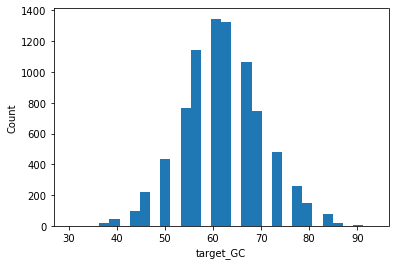

In [11]:
# Calculate and plot the GC contents of the target regions
filters.calc_gc_for_probe_dict(probe_dict, column_key_seq='target_sequence', column_key_write='target_GC')
plot.plot_hist(probe_dict, column_key='target_GC')

FLNA
	ENST00000369856.7: 6402 / 8212 probes passed the filter 43 < target_GC <  70.


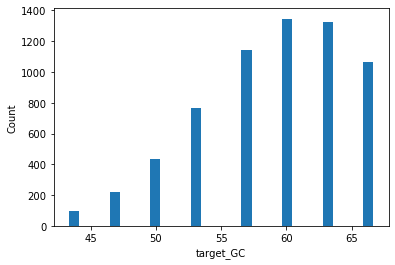

In [12]:
# Filter GC cotent and plot the GC content after filtering
filters.filter_probe_dict_by_metric(probe_dict, 'target_GC', lower_bound=43, upper_bound=70)
plot.plot_hist(probe_dict, column_key='target_GC')

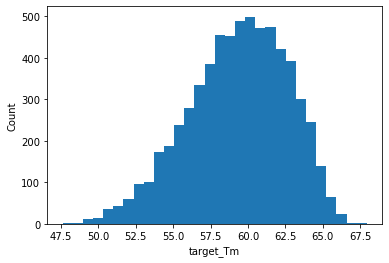

In [13]:
# Calculate and plot the melting-temperatures (Tm)
filters.calc_tm_for_probe_dict(probe_dict, Na_conc=390, fmd_percentile=30, probe_conc=5,
                              column_key_seq='target_sequence', column_key_write='target_Tm')
plot.plot_hist(probe_dict, column_key='target_Tm')

FLNA
	ENST00000369856.7: 6381 / 6402 probes passed the filter 50 < target_Tm <  inf.


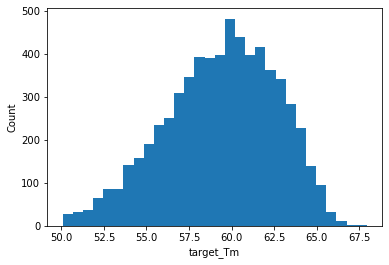

In [14]:
# Filter by Tm
# NOTE: here we used a higher upper bound for GC content and Tm than JM's original
# cutoffs. It was shown that higher Tm gives better signal-to-noise ratios in SM-FISH
filters.filter_probe_dict_by_metric(probe_dict, 'target_Tm', lower_bound=50)
plot.plot_hist(probe_dict, column_key='target_Tm')

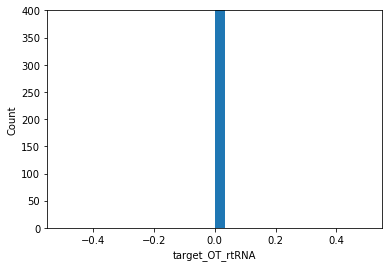

FLNA
	ENST00000369856.7: 6381 / 6381 probes passed the filter -inf < target_OT_rtRNA <  0.5.


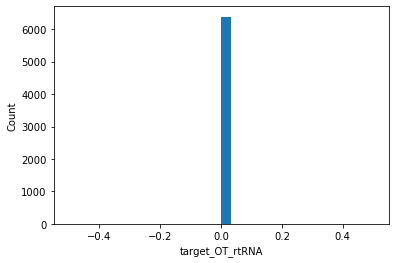

In [15]:
# Calculate and plot the off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_sequence', 'target_OT_rtRNA', 15)
plot.plot_hist(probe_dict, 'target_OT_rtRNA', y_max=400)
# Filter out probes that have any rRNA/tRNA off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_OT_rtRNA', upper_bound=0.5)
plot.plot_hist(probe_dict, 'target_OT_rtRNA')

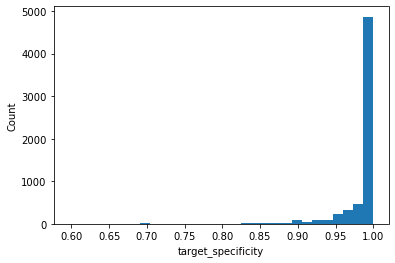

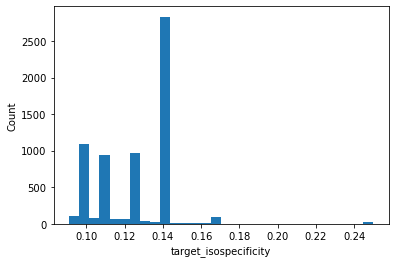

In [16]:
# Get the FPKMs of the transcripts
transcript_fpkms = dict(zip(list(transcriptome['transcript_id']), list(transcriptome['FPKM'])))

# Calculate the specificities and isoform specificities of the target regions
ot.calc_specificity(probe_dict, ottable_transcriptome, gene_ottable_dict, transcript_fpkms,
                    'target_sequence', 'target_specificity', 'target_isospecificity', 17)

plot.plot_hist(probe_dict, 'target_specificity')
plot.plot_hist(probe_dict, 'target_isospecificity')

FLNA
	ENST00000369856.7: 4418 / 6381 probes passed the filter 0.99999 < target_specificity <  inf.


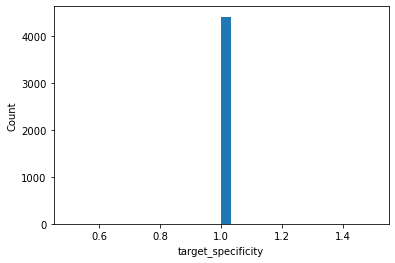

In [17]:
# Filter the specificities of the target regions
# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_specificity', lower_bound=0.99999)
plot.plot_hist(probe_dict, 'target_specificity')

# Design readout sequences

In [18]:
# Make a data frame of readout sequences
readout_seqs = pd.DataFrame({'id':['RS0468', 'RS0548'], 
                             'sequence':['TCTATCATTACCCTCCTCCT', 'TATTCACCTTACAAACCCTC'], 
                             'on-bit':[0, 1]})
readout_seqs

,id,sequence,on-bit
0,RS0468,TCTATCATTACCCTCCTCCT,0
1,RS0548,TATTCACCTTACAAACCCTC,1


In [19]:
import importlib
importlib.reload(rs)

# Add the readout sequences. Here we randomly add 2 readout sequences to each probe.
# Add an "T" between the concatenated sequences.
# Force each probe to have the same readout sequence
rs.add_readout_seqs_to_probes_random(probe_dict, readout_seqs, barcode_table, 2, 
                                     spacer='T', gene_id_key='name', each_probe_1_on_bit=True)
probe_dict['FLNA']['ENST00000369856.7']

Added readout sequences to 4418 probes.


,gene_id,transcript_id,shift,target_sequence,target_GC,target_Tm,target_OT_rtRNA,target_specificity,target_isospecificity,readout_names,probe_barcode,target_readout_sequence
104,FLNA,ENST00000369856.7,104,AGATCCAGCAGAACACTTTCACGCGCTGGT,53.333333,56.687718,0,1.0,0.142857,RS0548::RS0548,01,TATTCACCTTACAAACCCTCTAGATCCAGCAGAACACTTTCACGCG...
105,FLNA,ENST00000369856.7,105,GATCCAGCAGAACACTTTCACGCGCTGGTG,56.666667,56.239523,0,1.0,0.142857,RS0548::RS0548,01,TATTCACCTTACAAACCCTCTGATCCAGCAGAACACTTTCACGCGC...
106,FLNA,ENST00000369856.7,106,ATCCAGCAGAACACTTTCACGCGCTGGTGC,56.666667,57.730189,0,1.0,0.142857,RS0468::RS0468,10,TCTATCATTACCCTCCTCCTTATCCAGCAGAACACTTTCACGCGCT...
107,FLNA,ENST00000369856.7,107,TCCAGCAGAACACTTTCACGCGCTGGTGCA,56.666667,58.757350,0,1.0,0.142857,RS0548::RS0548,01,TATTCACCTTACAAACCCTCTTCCAGCAGAACACTTTCACGCGCTG...
131,FLNA,ENST00000369856.7,131,GGTGCAACGAGCACCTGAAGTGCGTGAGCA,60.000000,59.026623,0,1.0,0.142857,RS0468::RS0468,10,TCTATCATTACCCTCCTCCTTGGTGCAACGAGCACCTGAAGTGCGT...
...,...,...,...,...,...,...,...,...,...,...,...,...
8196,FLNA,ENST00000369856.7,8196,GTTCTCTTCTCCAGCCAAGAGGAATAAAGT,43.333333,50.561005,0,1.0,0.166667,RS0468::RS0468,10,TCTATCATTACCCTCCTCCTTGTTCTCTTCTCCAGCCAAGAGGAAT...
8201,FLNA,ENST00000369856.7,8201,CTTCTCCAGCCAAGAGGAATAAAGTTTTGC,43.333333,50.678963,0,1.0,0.166667,RS0468::RS0468,10,TCTATCATTACCCTCCTCCTTCTTCTCCAGCCAAGAGGAATAAAGT...
8204,FLNA,ENST00000369856.7,8204,CTCCAGCCAAGAGGAATAAAGTTTTGCTTC,43.333333,50.678963,0,1.0,0.166667,RS0548::RS0548,01,TATTCACCTTACAAACCCTCTCTCCAGCCAAGAGGAATAAAGTTTT...
8205,FLNA,ENST00000369856.7,8205,TCCAGCCAAGAGGAATAAAGTTTTGCTTCC,43.333333,52.261310,0,1.0,0.166667,RS0468::RS0468,10,TCTATCATTACCCTCCTCCTTTCCAGCCAAGAGGAATAAAGTTTTG...


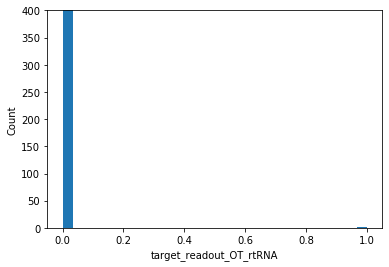

FLNA
	ENST00000369856.7: 4417 / 4418 probes passed the filter -inf < target_readout_OT_rtRNA <  0.5.


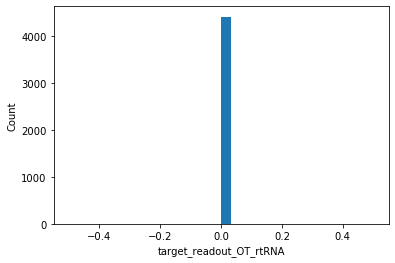

In [20]:
# Filter out probes that have off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_readout_sequence', 'target_readout_OT_rtRNA', 15)
plot.plot_hist(probe_dict, 'target_readout_OT_rtRNA', y_max=400)
filters.filter_probe_dict_by_metric(probe_dict, 'target_readout_OT_rtRNA', upper_bound=0.5)
plot.plot_hist(probe_dict, 'target_readout_OT_rtRNA')

/home/xingjie/Softwares/ZhuangLab/MERFISH_probe_design/MERFISH_probe_design/probe_design/OTTable_dict.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probe_dict[gk][tk][ot_key] = pd.Series((np.array(ots2) - np.array(ots1)) / weight, index=probe_dict[gk][tk].index)


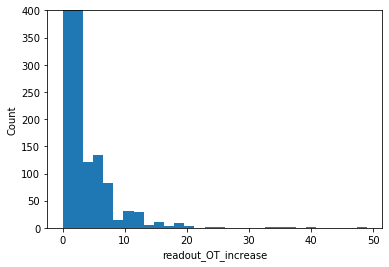

In [21]:
# Calculate how many more off-targets to the transcriptome are introduced due to the readout sequences.
# The off-target counts are weighted down by the FPKMs of the on-target transcripts
ot.calc_OT_diffs(probe_dict, ottable_transcriptome, gene_ottable_dict, transcript_fpkms, 
                 'target_sequence', 'target_readout_sequence', 'readout_OT_increase', 17)
plot.plot_hist(probe_dict, 'readout_OT_increase', y_max=400)

FLNA
	ENST00000369856.7: 2939 / 4417 probes passed the filter -inf < readout_OT_increase <  0.5.


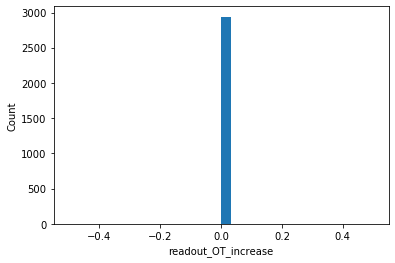

In [22]:
# Filter out the probes with extra off-targets due to the readouts
# Require the new weighted off-targets to be minor compared to the on-target weight.
filters.filter_probe_dict_by_metric(probe_dict, 'readout_OT_increase', upper_bound=0.5)
plot.plot_hist(probe_dict, 'readout_OT_increase')

# Select probes

In [23]:
%%time
# Select probes by a stochastic greedy algorithms that optimizes the on-bit coverage
# and minimizes the overlapping between probes.
ps.select_probes_greedy_stochastic(probe_dict, N_probes_per_transcript=48, N_on_bits=2)

FLNA:ENST00000369856.7: selected 48/2939 probes with N_overlapping_bases=0.0 and on-bit_coverage={0: 24, 1: 24}.
CPU times: user 4.92 ms, sys: 136 ms, total: 141 ms
Wall time: 27.6 s


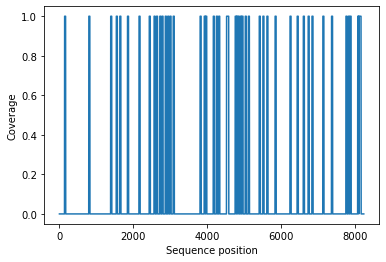

In [24]:
# Let's plot the probe coverage of an example transcript
seq_len = len(transcriptome[transcriptome['transcript_id'] == 'ENST00000369856.7'].iloc[0]['sequence'])
plot.plot_sequence_coverage(probe_dict['FLNA']['ENST00000369856.7'], seq_len)

# Quality check

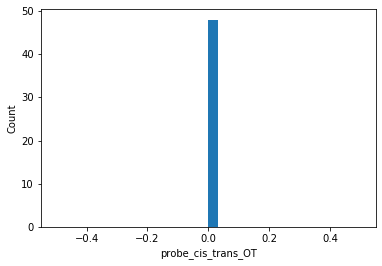

CPU times: user 95.9 ms, sys: 0 ns, total: 95.9 ms
Wall time: 95.5 ms


In [25]:
%%time
# Filter out the probes that self complement or complement with other probes.

# Iterately remove the probes with high numbers of cis/trans-complementarity
# This filtering strategy is a compromise between speed and the number of probes to keep
while True:
    # Make a OTTable from the reverse-complement sequences of the probes.
    ottable_probes_rc = ot.get_OTTable_for_probe_dictionary(probe_dict, 'target_readout_sequence', 15, rc=True)
    
    # The off-targets in this table indicates cis/trans-complementarity
    ot.calc_OTs(probe_dict, ottable_probes_rc, 'target_readout_sequence', 'probe_cis_trans_OT', 15)
    max_ot = max(plot.get_values_from_probe_dict(probe_dict, 'probe_cis_trans_OT'))
    if max_ot == 0:
        break
    
    # Remove probes that have any cis/trans-complementarity
    filters.filter_probe_dict_by_metric(probe_dict, 'probe_cis_trans_OT', upper_bound=max_ot - 0.5)
    
plot.plot_hist(probe_dict, 'probe_cis_trans_OT')

In [26]:
# Get the reverse-complementary sequences of the designed probes
p_d.get_rc_sequences(probe_dict, 'target_readout_sequence', 'target_readout_sequence_rc')

# Get a data frame of all probes
df_all_probes = p_d.probe_dict_to_df(probe_dict).sort_values(['probe_barcode', 'shift'])

# Make a column of probe names
probe_names = np.array(df_all_probes['gene_id']) + '_' + np.array(df_all_probes['transcript_id'])
probe_names = probe_names + '_shift:' + np.array(df_all_probes['shift']).astype(str)
probe_names = probe_names + '_GC:' + np.array(df_all_probes['target_GC']).astype('|S4').astype(str)
probe_names = probe_names + '_Tm:' + np.array(df_all_probes['target_Tm']).astype('|S4').astype(str)
probe_names = probe_names + '_specificity:' + np.array(df_all_probes['target_specificity']).astype('|S1').astype(str)
probe_names = probe_names + '_isospecificity:' + np.array(df_all_probes['target_isospecificity']).astype('|S4').astype(str)
probe_names = probe_names + '_' + np.array(df_all_probes['readout_names'])
df_all_probes['probe_names'] = probe_names

# Write the designed probes
df_all_probes.to_csv(probe_output_file, index=False)

In [27]:
df_all_probes

,gene_id,transcript_id,shift,target_sequence,target_GC,target_Tm,target_OT_rtRNA,target_specificity,target_isospecificity,readout_names,probe_barcode,target_readout_sequence,target_readout_OT_rtRNA,readout_OT_increase,probe_cis_trans_OT,target_readout_sequence_rc,probe_names
794,FLNA,ENST00000369856.7,794,CTCCCTTGCGGCCCAAACTGAACCCGAAGA,60.000000,60.860210,0,1.0,0.142857,RS0548::RS0548,01,TATTCACCTTACAAACCCTCTCTCCCTTGCGGCCCAAACTGAACCC...,0,0.0,0,GAGGGTTTGTAAGGTGAATAATCTTCGGGTTCAGTTTGGGCCGCAA...,FLNA_ENST00000369856.7_shift:794_GC:60.0_Tm:60...
1841,FLNA,ENST00000369856.7,1841,AATGTGACGACAAGGGCGACGGCTCCTGTG,60.000000,59.318474,0,1.0,0.125000,RS0548::RS0548,01,TATTCACCTTACAAACCCTCTAATGTGACGACAAGGGCGACGGCTC...,0,0.0,0,GAGGGTTTGTAAGGTGAATAACACAGGAGCCGTCGCCCTTGTCGTC...,FLNA_ENST00000369856.7_shift:1841_GC:60.0_Tm:5...
2430,FLNA,ENST00000369856.7,2430,CGAAGCTGACATCGACTTCGACATCATCCG,53.333333,53.234946,0,1.0,0.142857,RS0548::RS0548,01,TATTCACCTTACAAACCCTCTCGAAGCTGACATCGACTTCGACATC...,0,0.0,0,GAGGGTTTGTAAGGTGAATAACGGATGATGTCGAAGTCGATGTCAG...,FLNA_ENST00000369856.7_shift:2430_GC:53.3_Tm:5...
2775,FLNA,ENST00000369856.7,2775,CACAGTCAAGTACACGCCTGTCCAGCAGGG,60.000000,58.154477,0,1.0,0.142857,RS0548::RS0548,01,TATTCACCTTACAAACCCTCTCACAGTCAAGTACACGCCTGTCCAG...,0,0.0,0,GAGGGTTTGTAAGGTGAATAACCCTGCTGGACAGGCGTGTACTTGA...,FLNA_ENST00000369856.7_shift:2775_GC:60.0_Tm:5...
2992,FLNA,ENST00000369856.7,2992,TCCAAGATTGTGGGCCCCTCGGGTGCAGCG,66.666667,64.488627,0,1.0,0.142857,RS0548::RS0548,01,TATTCACCTTACAAACCCTCTTCCAAGATTGTGGGCCCCTCGGGTG...,0,0.0,0,GAGGGTTTGTAAGGTGAATAACGCTGCACCCGAGGGGCCCACAATC...,FLNA_ENST00000369856.7_shift:2992_GC:66.6_Tm:6...
3079,FLNA,ENST00000369856.7,3079,CCCCGTGAGGAAGGGCCCTATGAGGTGGAG,66.666667,63.154893,0,1.0,0.142857,RS0548::RS0548,01,TATTCACCTTACAAACCCTCTCCCCGTGAGGAAGGGCCCTATGAGG...,0,0.0,0,GAGGGTTTGTAAGGTGAATAACTCCACCTCATAGGGCCCTTCCTCA...,FLNA_ENST00000369856.7_shift:3079_GC:66.6_Tm:6...
3807,FLNA,ENST00000369856.7,3807,GTTCAGTGTGGACGCCCGGGCTCTGACACA,63.333333,61.045497,0,1.0,0.142857,RS0548::RS0548,01,TATTCACCTTACAAACCCTCTGTTCAGTGTGGACGCCCGGGCTCTG...,0,0.0,0,GAGGGTTTGTAAGGTGAATAATGTGTCAGAGCCCGGGCGTCCACAC...,FLNA_ENST00000369856.7_shift:3807_GC:63.3_Tm:6...
4164,FLNA,ENST00000369856.7,4164,CGAGGCCAAGATGTCCTGCATGGATAACAA,50.000000,54.994747,0,1.0,0.125000,RS0548::RS0548,01,TATTCACCTTACAAACCCTCTCGAGGCCAAGATGTCCTGCATGGAT...,0,0.0,0,GAGGGTTTGTAAGGTGAATAATTGTTATCCATGCAGGACATCTTGG...,FLNA_ENST00000369856.7_shift:4164_GC:50.0_Tm:5...
4248,FLNA,ENST00000369856.7,4248,CAACGTCACCTATGGTGGCCATCAAGTGCC,56.666667,57.729384,0,1.0,0.125000,RS0548::RS0548,01,TATTCACCTTACAAACCCTCTCAACGTCACCTATGGTGGCCATCAA...,0,0.0,0,GAGGGTTTGTAAGGTGAATAAGGCACTTGATGGCCACCATAGGTGA...,FLNA_ENST00000369856.7_shift:4248_GC:56.6_Tm:5...
4310,FLNA,ENST00000369856.7,4310,TGACAGATGCGTCCAAGGTCAAGTGCTCTG,53.333333,55.004014,0,1.0,0.125000,RS0548::RS0548,01,TATTCACCTTACAAACCCTCTTGACAGATGCGTCCAAGGTCAAGTG...,0,0.0,0,GAGGGTTTGTAAGGTGAATAACAGAGCACTTGACCTTGGACGCATC...,FLNA_ENST00000369856.7_shift:4310_GC:53.3_Tm:5...


The example designed probes and imaging result can be found under the directory: `MERFISH_probe_design/tests_and_examples/data/example_single_molecule_probe_design` 